In [58]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
import SimpleITK as sitk
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam



In [59]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [60]:
annotations_file = r'C:\Users\user\Downloads\pfa\CSVFILES\annotations.csv'
annotations_table = pd.read_csv(annotations_file)

candidates_file = r'C:\Users\user\Downloads\pfa\CSVFILES\candidates.csv'
candidates_table = pd.read_csv(candidates_file)

In [61]:
def get_voxel_Z(self,z):
        """
        Converts Cartesian to voxel coordinates
        """
        origin = self.GetOrigin()
        resolution = self.GetSpacing()
        zz=(z-origin[2])/resolution[2]
        return zz

In [62]:
def getImage(img_id):
    normal=[]
    nodule=[]
    z_list=[]
    img_ITK=sitk.BinShrink(sitk.ReadImage('C:/Users/user/Downloads/pfa/dataset/'+ img_id + '.mhd', sitk.sitkFloat32),[16,16,1])
    img_np= sitk.GetArrayFromImage(img_ITK)
    bboxs = annotations_table[annotations_table['seriesuid']==img_id]
    for index, row in bboxs.iterrows():
        z=row['coordZ']
        zz=int(get_voxel_Z(img_ITK,z))
        z_list=z_list+[zz]
        p= tf.expand_dims(img_np[zz], axis=-1)
        nodule=nodule+[p]

        
    for i in range(img_np.shape[0]):
        if i not in z_list:
            k= tf.expand_dims(img_np[i], axis=-1)
            normal=normal+[k]
    
    return(normal,nodule)

In [63]:
normal_scans=[]
abnormal_scans=[]
i=0
for img_id in annotations_table['seriesuid']:
    if i<21 :
        (normal,nodule)=getImage(img_id)
        normal_scans=normal_scans+normal
        abnormal_scans=abnormal_scans+nodule
        i=i+1
    else : break


    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).   
print("CT scans with normal lung : " + str(len(normal_scans)))
print("CT scans with nodules : " + str(len(abnormal_scans)))



CT scans with normal lung : 4837
CT scans with nodules : 57


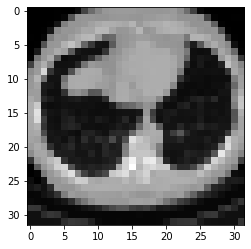

In [64]:
plt.imshow(abnormal_scans[0])
plt.axis("on")
plt.gray()
plt.show()


In [65]:
abnormal_scans=np.array([abnormal_scans[i] for i in range(len(abnormal_scans))])
normal_scans=np.array([normal_scans[i] for i in range(len(normal_scans))])



abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:40], normal_scans[:3386]), axis=0)
y_train = np.concatenate((abnormal_labels[:40], normal_labels[:3386]), axis=0)
x_test = np.concatenate((abnormal_scans[40:], normal_scans[3386:]), axis=0)
y_test = np.concatenate((abnormal_labels[40:], normal_labels[3386:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], y_test.shape[0])
)

Number of samples in train and validation are 3426 and 1468.


In [66]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [67]:

# Input image dimensions.
input_shape = x_train.shape[1:]


NUM_CLASSES=np.unique(y_train).shape[0]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255



print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)




x_train shape: (3426, 32, 32, 1)
3426 train samples
1468 test samples
y_train shape: (3426,)


In [68]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [79]:
def resnet_v1(input_shape, depth, num_classes=2):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # Start model definition.
    num_filters = 16
    num_res_blocks = int(depth)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [80]:
model = resnet_v1(input_shape=input_shape, depth=1)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 16)   160         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 16)   64          conv2d_18[0][0]                  
__________________________________________________________________________________________________
activation_358 (Activation)     (None, 32, 32, 16)   0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [81]:


start_time = time.time()
'''
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
              '''


model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]
class_weight = {0: 1,
                1: 100}
# Run training, with or without data augmentation.
BATCH_SIZE=2
EPOCHS=10
    
history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks,
              class_weight=class_weight)

Epoch 1/10
Learning rate:  0.001
1713/1713 [==============================] - 34s 19ms/step - loss: 2.7915 - accuracy: 0.6488 - val_loss: 1.5871 - val_accuracy: 0.3215
Epoch 2/10
Learning rate:  0.001
1713/1713 [==============================] - 30s 18ms/step - loss: 1.2782 - accuracy: 0.6335 - val_loss: 1.6265 - val_accuracy: 0.1941
Epoch 3/10
Learning rate:  0.001
1713/1713 [==============================] - 31s 18ms/step - loss: 1.3274 - accuracy: 0.5763 - val_loss: 1.0398 - val_accuracy: 0.4387
Epoch 4/10
Learning rate:  0.001
1713/1713 [==============================] - 32s 19ms/step - loss: 1.2519 - accuracy: 0.6580 - val_loss: 0.9694 - val_accuracy: 0.4925
Epoch 5/10
Learning rate:  0.001
1713/1713 [==============================] - 36s 21ms/step - loss: 1.1415 - accuracy: 0.6574 - val_loss: 1.4706 - val_accuracy: 0.4591
Epoch 6/10
Learning rate:  0.001
1713/1713 [==============================] - 33s 19ms/step - loss: 1.0103 - accuracy: 0.7192 - val_loss: 1.0475 - val_accuracy:

46/46 - 1s - loss: 0.5262 - accuracy: 0.8358


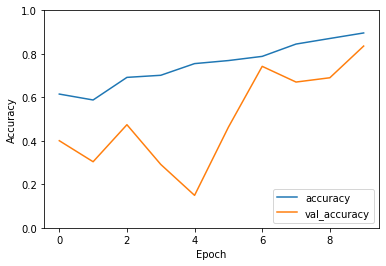

In [72]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)